In [1]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import deque

In [2]:
# This function returns the vectorized basis vector in R^n corresponding to the given action.
def vectorize_act(N, act):
    if act < 0 or act >= N:
        raise ValueError("act must be in the range [0, N-1]")
        
    vector = np.zeros(N)
    vector[act] = 1      # Set the i+1-th element to 1
    return vector


In [57]:
# Implementing the FTPL sequence generator. This function takes in the sum of cost vectors, epsilon for FTPL Algo and an optional argument seed.
# If seed is not None a truly random generator will be used. 
def FollowPerturbedLeader(sum_costs,epsilon,seed=None):
    # This function takes in the sum of costs thus far for each of the actions and outputs an action acc to FTPL.
    num_actions = len(sum_costs)

    # If seed is provided we define a new instance of a random class. This avoids changin the seed for the global random class. 
    if seed is not None:
        # Use a separate Random instance for seeding
        rng = np.random.default_rng(seed)
        perturbations = -rng.exponential(scale=1/epsilon, size=num_actions)   # Mean of exp(eps) is 1/eps
    else:
        # Use the default global Random instance for unseeded behavior
        perturbations = -np.random.exponential(scale=1/epsilon, size=num_actions)   # Mean of exp(eps) is 1/eps
    # print(perturbations)
    # Pick the action that achieves lowest cost.
    return np.argmin(sum_costs+perturbations)  


In [38]:
# Validating my FTPL generator.
# sum_costs = -np.zeros(10)
# sum_costs[0]=-1
# epsilon = math.sqrt(np.log(10)/100)
# FollowPerturbedLeader(sum_costs,epsilon)

In [39]:
# Implementing the ExpWeightsAlgo. Not really using this in my final version.
def ExpWeightsAlgo(prev_weights,current_cost,epsilon):
    num_actions = len(current_cost)
    # Probability of choosing each action.
    prob = prev_weights / np.sum(prev_weights)
    chosen_action = np.random.choice(np.arange(num_actions), p=prob)
    
    # Update weights based on the cost vector observed for the chosen action
    exponent = -epsilon * current_cost
    next_weights = prev_weights*np.exp(exponent)

    return next_weights,chosen_action 
    

Here I will write out the modifications of Algo 2 from Anava et al. paper to our framework where $\mathcal{K} = \{\text{basis vectors in }\mathbb{R}^n\}$ and $\tilde f^t(\cdot) = \langle g^t+\mathbb{1}, \cdot \rangle $. Note that their algorithm works on cost minimization when $\tilde f^t \in [0,1]$. We modify our cost function to satisfy this constraint by adding a constant $M=1$ to the function. This then ensures $\tilde f^t \in [0,1]$

First in the algorithm we have to pick $$\eta = \frac{2G}{D}\sqrt{\frac{1+(\log(T+1))}{mT}}.$$ For our problem picking $\|\cdot\|=\|\cdot\|_1$ we have $G=nM$ (bound on cost vector 1-norm), $D=2$ (1-norm diameter of set $\mathcal{K}$) and $m=H$ giving us
$$\eta = nM\sqrt{\frac{1+(\log(T+1))}{HT}}.$$

Next, for our implementation $\tilde f^t(x)=\langle g^t+M\mathbb{1}, x \rangle$ and so $$\hat f^t(x) = \tilde f^t(x) + \frac{\eta}{2} \|x\|^2 = \langle g^t + M\mathbb{1} + \frac{\eta}{2} \mathbb{1}, x \rangle.$$
The last equality is written by exploiting the identity that $\|x\|_1=1$ for every element of the simplex. So the weights for each element in the discrete set of size $n$ is updated as 
$$w^{t+1}_i = \exp{\bigg(-\alpha \sum_{\tau=1}^t \hat{f}^\tau(e_i)\bigg)} = \exp{\bigg(-\alpha \sum_{\tau=1}^t \big(g^\tau_i + \frac{\eta}{2} + M\big)\bigg)}= w^{t}_i \exp{\bigg(-\alpha \big(g^t_i + \frac{\eta}{2}+M \big)\bigg)}  $$
where $\alpha=\eta/4G^2 = \eta/4n^2$ when $M=1$.
These weights are always updated in every time step. They are then used to determine the step to be taken at every time instant. 

- If $i_t$ is the action taken at time $t$ then with probability $w^{t+1}_{i_t}/w^{t}_{i_t}$ we set $i_{t+1} = i_t$ 
- With $1-w^{t+1}_{i_t}/w^{t}_{i_t}$ probability a fresh action is picked for $$i_{t+1} = j \sim \frac{w^{t+1}_j}{\sum_k w^{t+1}_k}. $$

Let us implement this as a function.



In [107]:
###  Let us implement the approach 2 from Anava et al. as described above for our problem. 
# The function we define below is to be called after the action v^t has been taken and the cost is generated 
# from the corresponding x^t. It takes as input the previous action v^t, the cost vector just generated g^t, 
# the weight of each action w^t and the parameter eta. It outputs the new weights and the action to be taken now.
# It also assumes ||cur_cost|| in [0,1] otherwise return error.
def ShrinkDartOCOAlgo(cur_act, cur_cost, cur_wt, eta):
    # Check if the cost vector is in the range.
    if not np.all((cur_cost >= 0) & (cur_cost <= 1)):
        raise ValueError("Every actions cost must be in range [0, 1]. I got",cur_cost)
        
    # Storing the number of actions.
    num_actions = len(cur_cost)
    
    # Update weights based on the cost vector observed for the all action.
    alpha = eta/4/num_actions**2
    exponent = -alpha*(cur_cost + eta/2*np.ones(num_actions))
    nex_wt = cur_wt*np.exp(exponent)

    # Generate the next action.
    rv = np.random.uniform()
    print('RV:',rv,' Weight ratio',nex_wt[cur_act]/cur_wt[cur_act])
    if rv<=nex_wt[cur_act]/cur_wt[cur_act]:
        nex_act=cur_act
    else:
        nex_act=np.random.choice(np.arange(num_actions), p=nex_wt/np.sum(nex_wt))

    return nex_wt,nex_act

In [117]:
###  Let us also implement the original SD algo from Geulen et. al. since Anava approach does not seem to switch at all! 

# The function we define below is to be called after the action v^t has been taken and the cost is generated 
# from the corresponding x^t. It takes as input the previous action v^t, the cost vector just generated g^t, 
# the current weight of each action w^t and the parameter eta. It outputs the new weights and the action to be taken.
# It also assumes ||cur_cost|| in [0,1] otherwise return error.
def OG_SD_Alg(cur_act, cur_cost, cur_wt, eta):
    # Check if the cost vector is in the range.
    if not np.all((cur_cost >= 0) & (cur_cost <= 1)):
        raise ValueError("Every actions cost must be in range [0, 1]. I got",cur_cost)
        
    # Storing the number of actions.
    num_actions = len(cur_cost)
    
    # Update weights based on the cost vector observed for the all action.
    nex_wt = cur_wt*(1-eta)**cur_cost

    # Generate the next action.
    rv = np.random.uniform()
    # print('RV:',rv,' Weight ratio of current act:',nex_wt[cur_act]/cur_wt[cur_act])
    if rv<=nex_wt[cur_act]/cur_wt[cur_act]:
        nex_act=cur_act
    else:
        nex_act=np.random.choice(np.arange(num_actions), p=nex_wt/np.sum(nex_wt))

    return nex_wt,nex_act

In [118]:
n=5
T=10000
H=10
wt=np.ones(n)
eta = np.sqrt((np.log(n))/(H*T))
act=np.random.choice(np.arange(n))

# Cost vector 
c=np.ones(n)
c[0]=0
wt,act=OG_SD_Alg(act, c, wt, eta)
wt,act

(array([1.        , 0.99598822, 0.99598822, 0.99598822, 0.99598822]), 2)

In [120]:
# Cost vector 
for t in range(T):
    c=np.ones(n)
    c[0]=0
    wt,act=OG_SD_Alg(act, c, wt, eta)
    # print(wt,act)

In [121]:
# Let us now setup the finite horizon averaging class.
class TimeAverageCalculator:
    def __init__(self, h):
        self.h = h
        self.vectors = deque(maxlen=h)
        self.total_sum = np.array([])
        self.t = 0

    def add_vector(self, v):
        # Increment time step
        self.t += 1

        if self.t <= self.h:
            # For the first h steps, sum vectors and compute average
            if self.t == 1:
                self.total_sum = np.array(v)
            else:
                self.total_sum += v
        else:
            # After h steps, remove the oldest vector's contribution and add the new vector's contribution
            if len(self.vectors) == self.h:
                self.total_sum -= self.vectors[0]
            self.total_sum += v

        # Append the new vector
        self.vectors.append(v)

        # Calculate the time average
        return self.total_sum / min(self.t, self.h)

# Test cases
# time_avg_calculator = TimeAverageCalculator(h=3)

# vectors = [np.array([1, 2]), np.array([2, 3]), np.array([3, 4]), np.array([4, 5]), np.array([5, 6])]

# for v in vectors:
#     x_t = time_avg_calculator.add_vector(v)
#     print(f"x^t: {x_t}")


RV: 0.8246474584932676  Weight ratio of current act: 0.999639118122105
RV: 0.9111373726875548  Weight ratio of current act: 0.9997965395737524
RV: 0.4315436381109008  Weight ratio of current act: 0.9998955014839349
RV: 0.878986303387111  Weight ratio of current act: 0.9997205202628193
RV: 0.501989985085208  Weight ratio of current act: 0.999654735166539
RV: 0.47734762205677783  Weight ratio of current act: 0.9996518001038602
RV: 0.7605174062541163  Weight ratio of current act: 0.9998745652530309
RV: 0.9299646810200531  Weight ratio of current act: 0.9997072053480148
RV: 0.43900102208045644  Weight ratio of current act: 0.9996961889125155
RV: 0.02429517896452915  Weight ratio of current act: 0.99970358093456
RV: 0.47345456167225763  Weight ratio of current act: 0.9999662197878769
RV: 0.5765863179023176  Weight ratio of current act: 0.9996607198866952
RV: 0.05388198753514817  Weight ratio of current act: 0.9998964575268431
RV: 0.052388330889920565  Weight ratio of current act: 0.99983103

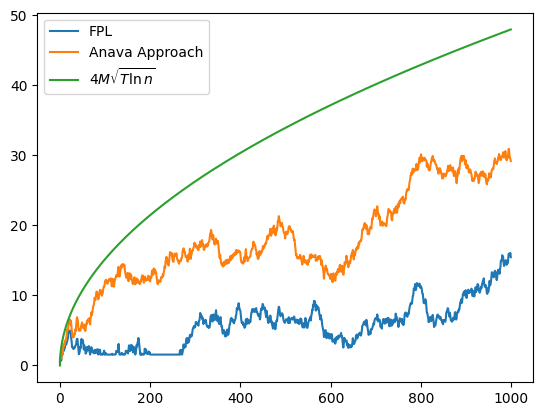

In [108]:
# Let us now implement both the algorithms listed above on stochastically generated homogenous cost for each action.
T = 1000 # Time Horizon
H = 10   # History Horizon
N = 10   # Number of actions

# 1. Stochastically generated homogenous cost functions. Each action costs uniform [0,1].
M=1

# Defining eps/eta value for history dependent FTPL and SDAlgo.
eps_FPL_Hist = 2/M*math.sqrt((np.log(N)+1)/(T-H)/(H+2))  # From Hebbar and Langbort paper.
eta_SD_Alg = n*M*np.sqrt((1+np.log(T+1))/(H*T))        # Anava et. al paper. 

# Generate sequence of cost functions.
sum_cost_vec=np.zeros(N)          # This is updated every round.
sum_cost_vec_list=np.zeros([T,N]) # Saving the sum of cost vectors until every time step for plotting purpose. This is just for sanity checks during plotting can delete this later. 

# Storing incurred costs and regret of History Dep FPL
tot_cost_FPL=0                    # Total cost incurred so far.      
tot_cost_list_FPL=np.zeros(T)     # Saving the cost incurred so far at every step for regret plotting. 
regret_FPL = np.zeros(T)          # Saving the regret at every step for plotting.

# Generating seed for FTPL.
# We pick a randomized but constant seed for FTPL perturbations generation. 
# If we want a new perturbation everytime we will set seed=None FollowPerturbedLeader() is called.
seed_FPL = int(1000*(np.random.uniform()))

# Storing incurred costs and regret of SD_Algo.
tot_cost_SDAlg=0
tot_cost_list_SDAlg=np.zeros(T)
regret_SDAlg = np.zeros(T)
W = np.ones(N)                               # Initializing weights for SD Algo.
SDAlg_act = np.random.choice(np.arange(N))   # Initializing a random action for SD algo.

# Creating the time averaging dynamics classes - one copy each for the the FPL and SD algo.
time_avg_calculator_FPL = TimeAverageCalculator(h=H)
time_avg_calculator_SDAlg = TimeAverageCalculator(h=H)


for t in range(T):
    # Generate the FTPL action and state. We don't want  
    FPL_act=FollowPerturbedLeader(sum_cost_vec,eps_FPL_Hist,seed=seed_FPL)
    FPL_state = time_avg_calculator_FPL.add_vector(vectorize_act(N,FPL_act))
    # print('FPL Action:',vectorize_act(N,FPL_act), ' State:',FPL_state)
    
    # Generate the SDAlg state from the action already picked for this round.
    SDAlg_state = time_avg_calculator_SDAlg.add_vector(vectorize_act(N,SDAlg_act))
    # print('SDAlg Action:',vectorize_act(N,SDAlg_act), ' State:',SDAlg_state)
    
    # Generate the next cost function.
    cost_vec = -M*np.random.uniform(size=N)
    # print(cost_vec)
    sum_cost_vec+=cost_vec                    # FPL needs this for the next round.
    # sum_cost_vec_list[t]=sum_cost_vec         # Can comment this later don't need this for anything but plotting   

    # Using the cost functions, past weights and past actions to generate the next action and state in the Anava et. al approach.
    W,SDAlg_act=ShrinkDartOCOAlgo(SDAlg_act, cost_vec+M*np.ones(N), W, eta_SD_Alg)
    
    # # Compute the cost incurred.
    tot_cost_FPL+=np.dot(cost_vec,FPL_state)
    tot_cost_list_FPL[t]=tot_cost_FPL
    tot_cost_SDAlg+=np.dot(cost_vec,SDAlg_state)
    tot_cost_list_SDAlg[t]=tot_cost_SDAlg
    
    # Obtaining the regret.
    regret_FPL[t]=tot_cost_FPL-np.min(sum_cost_vec)
    regret_SDAlg[t]=tot_cost_SDAlg-np.min(sum_cost_vec)
    
plt.plot(np.arange(T),regret_FPL,label='FPL')
plt.plot(np.arange(T),regret_SDAlg,label='Anava Approach')
# Here $H$ is a bad thing to incorporate because when things are randomized the states are also basically uniform spread 
# and in expectation give the same cost as taking each pure action. So the regret it comparable to the no history case.
plt.plot(np.arange(T),M*np.arange(T)**0.5*np.log(N)**0.5,label='$4M\sqrt{T \ln{n}}$')
# plt.plot(np.arange(T),M*np.arange(T)**0.5*np.log(N)**0.5*H**0.5,label='$4M\sqrt{TH \ln{n}}$')
plt.legend()


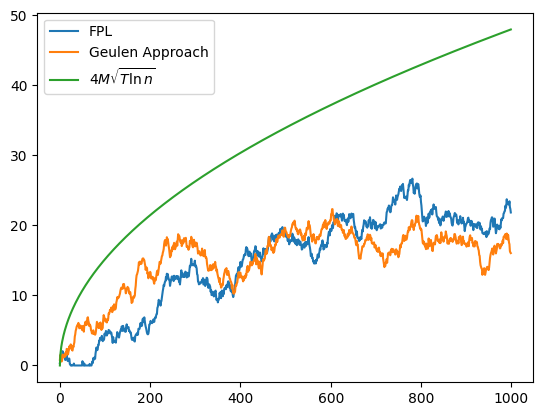

In [132]:
# Let us now implement both the OG_SD and FTAPL algos on stochastically generated homogenous cost for each action.
T = 1000 # Time Horizon
H = 10   # History Horizon
N = 10   # Number of actions

# 1. Stochastically generated homogenous cost functions. Each action costs uniform [0,1].
M=1

# Defining eps/eta value for history dependent FTPL and SDAlgo.
eps_FPL_Hist = 2/M*math.sqrt((np.log(N)+1)/(T-H)/(H+2))  # From Hebbar and Langbort paper.
eta_OG_SD = M*np.sqrt(np.log(N)/(H*T))                   # Geulen et. al paper. 

# Generate sequence of cost functions.
sum_cost_vec=np.zeros(N)          # This is updated every round.
sum_cost_vec_list=np.zeros([T,N]) # Saving the sum of cost vectors until every time step for plotting purpose. This is just for sanity checks during plotting can delete this later. 

# Storing incurred costs and regret of History Dep FPL
tot_cost_FPL=0                    # Total cost incurred so far.      
tot_cost_list_FPL=np.zeros(T)     # Saving the cost incurred so far at every step for regret plotting. 
regret_FPL = np.zeros(T)          # Saving the regret at every step for plotting.

# Generating seed for FTPL.
# We pick a randomized but constant seed for FTPL perturbations generation. 
# If we want a new perturbation everytime we will set seed=None FollowPerturbedLeader() is called.
seed_FPL = int(1000*(np.random.uniform()))

# Storing incurred costs and regret of SD_Algo.
tot_cost_OG_SD=0
tot_cost_list_OG_SD=np.zeros(T)
regret_OG_SD = np.zeros(T)
W = np.ones(N)                               # Initializing weights for SD Algo.
OG_SD_act = np.random.choice(np.arange(N))   # Initializing a random action for SD algo.

# Creating the time averaging dynamics classes - one copy each for the the FPL and SD algo.
time_avg_calculator_FPL = TimeAverageCalculator(h=H)
time_avg_calculator_OG_SD = TimeAverageCalculator(h=H)


for t in range(T):
    # Generate the FTPL action and state. We don't want  
    FPL_act=FollowPerturbedLeader(sum_cost_vec,eps_FPL_Hist,seed=seed_FPL)
    FPL_state = time_avg_calculator_FPL.add_vector(vectorize_act(N,FPL_act))
    # print('FPL Action:',vectorize_act(N,FPL_act), ' State:',FPL_state)
    
    # Generate the OG_SD state from the action already picked for this round.
    OG_SD_state = time_avg_calculator_OG_SD.add_vector(vectorize_act(N,OG_SD_act))
    # print('SDAlg Action:',vectorize_act(N,SDAlg_act), ' State:',SDAlg_state)
    
    # Generate the next cost function.
    cost_vec = -M*np.random.uniform(size=N)
    # print(cost_vec)
    sum_cost_vec+=cost_vec                    # FPL needs this for the next round.
    # sum_cost_vec_list[t]=sum_cost_vec         # Can comment this later don't need this for anything but plotting   

    # Using the cost functions, past weights and past actions to generate the next action and state in the Anava et. al approach.
    W,OG_SD_act=OG_SD_Alg(OG_SD_act, cost_vec+M*np.ones(N), W, eta_OG_SD)
    
    # # Compute the cost incurred.
    tot_cost_FPL+=np.dot(cost_vec,FPL_state)
    tot_cost_list_FPL[t]=tot_cost_FPL
    tot_cost_OG_SD+=np.dot(cost_vec,OG_SD_state)
    tot_cost_list_OG_SD[t]=tot_cost_OG_SD
    
    # Obtaining the regret.
    regret_FPL[t]=tot_cost_FPL-np.min(sum_cost_vec)
    regret_OG_SD[t]=tot_cost_OG_SD-np.min(sum_cost_vec)
    
plt.plot(np.arange(T),regret_FPL,label='FPL')
plt.plot(np.arange(T),regret_OG_SD,label='Geulen Approach')
# Here $H$ is a bad thing to incorporate because when things are randomized the states are also basically uniform spread 
# and in expectation give the same cost as taking each pure action. So the regret it comparable to the no history case.
plt.plot(np.arange(T),M*np.arange(T)**0.5*np.log(N)**0.5,label='$4M\sqrt{T \ln{n}}$')
# plt.plot(np.arange(T),M*np.arange(T)**0.5*np.log(N)**0.5*H**0.5,label='$4M\sqrt{TH \ln{n}}$')
plt.legend()


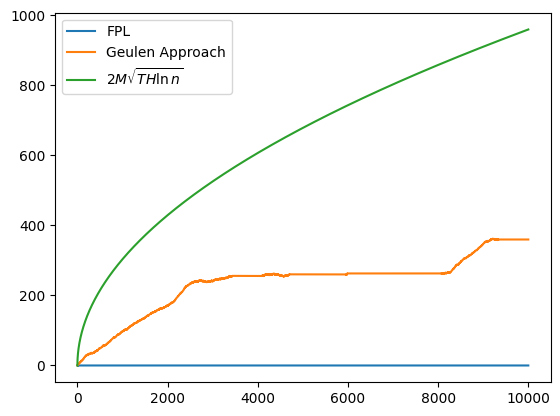

In [131]:
# Let us now implement both the OG_SD and FTAPL algos on stochastically generated heterogenous cost for each action.
T = 10000 # Time Horizon
H = 10   # History Horizon
N = 10   # Number of actions

# 2. Stochastically generated heterogenous cost functions.
# Randomly generate the lower and upperbounds of n uniform RVs that will give us the cost function. 
a = -0.2*np.random.uniform(size=N)
b = a-0.8*np.random.uniform(size=N)

# The clearly we have.
M=1


# Defining eps/eta value for history dependent FTPL and SDAlgo.
eps_FPL_Hist = 2/M*math.sqrt((np.log(N)+1)/(T-H)/(H+2))  # From Hebbar and Langbort paper.
eta_OG_SD = M*np.sqrt(np.log(N)/(H*T))                   # Geulen et. al paper. 

# Generate sequence of cost functions.
sum_cost_vec=np.zeros(N)          # This is updated every round.
sum_cost_vec_list=np.zeros([T,N]) # Saving the sum of cost vectors until every time step for plotting purpose. This is just for sanity checks during plotting can delete this later. 

# Storing incurred costs and regret of History Dep FPL
tot_cost_FPL=0                    # Total cost incurred so far.      
tot_cost_list_FPL=np.zeros(T)     # Saving the cost incurred so far at every step for regret plotting. 
regret_FPL = np.zeros(T)          # Saving the regret at every step for plotting.

# Generating seed for FTPL.
# We pick a randomized but constant seed for FTPL perturbations generation. 
# If we want a new perturbation everytime we will set seed=None FollowPerturbedLeader() is called.
seed_FPL = int(1000*(np.random.uniform()))

# Storing incurred costs and regret of SD_Algo.
tot_cost_OG_SD=0
tot_cost_list_OG_SD=np.zeros(T)
regret_OG_SD = np.zeros(T)
W = np.ones(N)                               # Initializing weights for SD Algo.
OG_SD_act = np.random.choice(np.arange(N))   # Initializing a random action for SD algo.

# Creating the time averaging dynamics classes - one copy each for the the FPL and SD algo.
time_avg_calculator_FPL = TimeAverageCalculator(h=H)
time_avg_calculator_OG_SD = TimeAverageCalculator(h=H)


for t in range(T):
    # Generate the FTPL action and state. We don't want  
    FPL_act=FollowPerturbedLeader(sum_cost_vec,eps_FPL_Hist,seed=seed_FPL)
    FPL_state = time_avg_calculator_FPL.add_vector(vectorize_act(N,FPL_act))
    # print('FPL Action:',vectorize_act(N,FPL_act), ' State:',FPL_state)
    
    # Generate the OG_SD state from the action already picked for this round.
    OG_SD_state = time_avg_calculator_OG_SD.add_vector(vectorize_act(N,OG_SD_act))
    # print('SDAlg Action:',vectorize_act(N,SDAlg_act), ' State:',SDAlg_state)
    
    # Generate the next cost function.
    cost_vec = np.random.uniform(b,a)
    # print(cost_vec)
    sum_cost_vec+=cost_vec                    # FPL needs this for the next round.
    # sum_cost_vec_list[t]=sum_cost_vec         # Can comment this later don't need this for anything but plotting   

    # Using the cost functions, past weights and past actions to generate the next action and state in the Anava et. al approach.
    W,OG_SD_act=OG_SD_Alg(OG_SD_act, cost_vec+M*np.ones(N), W, eta_OG_SD)
    
    # # Compute the cost incurred.
    tot_cost_FPL+=np.dot(cost_vec,FPL_state)
    tot_cost_list_FPL[t]=tot_cost_FPL
    tot_cost_OG_SD+=np.dot(cost_vec,OG_SD_state)
    tot_cost_list_OG_SD[t]=tot_cost_OG_SD
    
    # Obtaining the regret.
    regret_FPL[t]=tot_cost_FPL-np.min(sum_cost_vec)
    regret_OG_SD[t]=tot_cost_OG_SD-np.min(sum_cost_vec)
    
plt.plot(np.arange(T),regret_FPL,label='FPL')
plt.plot(np.arange(T),regret_OG_SD,label='Geulen Approach')
# Here $H$ is a bad thing to incorporate because when things are randomized the states are also basically uniform spread 
# and in expectation give the same cost as taking each pure action. So the regret it comparable to the no history case.
# plt.plot(np.arange(T),M*np.arange(T)**0.5*np.log(N)**0.5,label='$4M\sqrt{T \ln{n}}$')
plt.plot(np.arange(T),2*M*np.arange(T)**0.5*np.log(N)**0.5*H**0.5,label='$2M\sqrt{TH \ln{n}}$')
plt.legend()


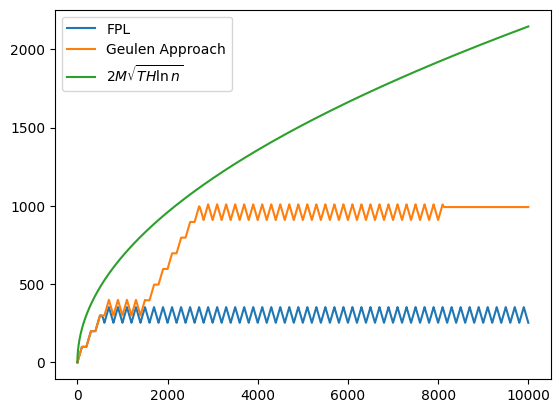

In [141]:
# Let us now implement both the OG_SD and FTAPL algos on round robin cost for each action.
T = 10000 # Time Horizon
H = 50   # History Horizon
N = 10   # Number of actions

# 3. Round robin cost functions with L length lock.
L=100

# Each of the N cost functions will occur in round robin fashion switching after a period of L at a time. 
costs=-1*np.eye(N)

# Clearly then our upperbound on the size of the cost vector is 1.
M=1

# Defining eps/eta value for history dependent FTPL and SDAlgo.
eps_FPL_Hist = 2/M*math.sqrt((np.log(N)+1)/(T-H)/(H+2))  # From Hebbar and Langbort paper.
eta_OG_SD = M*np.sqrt(np.log(N)/(H*T))                   # Geulen et. al paper. 

# Generate sequence of cost functions.
sum_cost_vec=np.zeros(N)          # This is updated every round.
sum_cost_vec_list=np.zeros([T,N]) # Saving the sum of cost vectors until every time step for plotting purpose. This is just for sanity checks during plotting can delete this later. 

# Storing incurred costs and regret of History Dep FPL
tot_cost_FPL=0                    # Total cost incurred so far.      
tot_cost_list_FPL=np.zeros(T)     # Saving the cost incurred so far at every step for regret plotting. 
regret_FPL = np.zeros(T)          # Saving the regret at every step for plotting.

# Generating seed for FTPL.
# We pick a randomized but constant seed for FTPL perturbations generation. 
# If we want a new perturbation everytime we will set seed=None FollowPerturbedLeader() is called.
seed_FPL = int(1000*(np.random.uniform()))

# Storing incurred costs and regret of SD_Algo.
tot_cost_OG_SD=0
tot_cost_list_OG_SD=np.zeros(T)
regret_OG_SD = np.zeros(T)
W = np.ones(N)                               # Initializing weights for SD Algo.
OG_SD_act = np.random.choice(np.arange(N))   # Initializing a random action for SD algo.

# Creating the time averaging dynamics classes - one copy each for the the FPL and SD algo.
time_avg_calculator_FPL = TimeAverageCalculator(h=H)
time_avg_calculator_OG_SD = TimeAverageCalculator(h=H)


for t in range(T):
    # Generate the FTPL action and state. We don't want  
    FPL_act=FollowPerturbedLeader(sum_cost_vec,eps_FPL_Hist,seed=seed_FPL)
    FPL_state = time_avg_calculator_FPL.add_vector(vectorize_act(N,FPL_act))
    # print('FPL Action:',vectorize_act(N,FPL_act), ' State:',FPL_state)
    
    # Generate the OG_SD state from the action already picked for this round.
    OG_SD_state = time_avg_calculator_OG_SD.add_vector(vectorize_act(N,OG_SD_act))
    # print('SDAlg Action:',vectorize_act(N,SDAlg_act), ' State:',SDAlg_state)
    
    # Generate the next cost function.
    cost_vec = costs[(int(t/L))%2,:]
    # print(cost_vec)
    sum_cost_vec+=cost_vec                    # FPL needs this for the next round.
    # sum_cost_vec_list[t]=sum_cost_vec         # Can comment this later don't need this for anything but plotting   

    # Using the cost functions, past weights and past actions to generate the next action and state in the Anava et. al approach.
    W,OG_SD_act=OG_SD_Alg(OG_SD_act, cost_vec+M*np.ones(N), W, eta_OG_SD)
    
    # # Compute the cost incurred.
    tot_cost_FPL+=np.dot(cost_vec,FPL_state)
    tot_cost_list_FPL[t]=tot_cost_FPL
    tot_cost_OG_SD+=np.dot(cost_vec,OG_SD_state)
    tot_cost_list_OG_SD[t]=tot_cost_OG_SD
    
    # Obtaining the regret.
    regret_FPL[t]=tot_cost_FPL-np.min(sum_cost_vec)
    regret_OG_SD[t]=tot_cost_OG_SD-np.min(sum_cost_vec)
    
plt.plot(np.arange(T),regret_FPL,label='FPL')
plt.plot(np.arange(T),regret_OG_SD,label='Geulen Approach')
# Here $H$ is a bad thing to incorporate because when things are randomized the states are also basically uniform spread 
# and in expectation give the same cost as taking each pure action. So the regret it comparable to the no history case.
# plt.plot(np.arange(T),M*np.arange(T)**0.5*np.log(N)**0.5,label='$4M\sqrt{T \ln{n}}$')
plt.plot(np.arange(T),2*M*np.arange(T)**0.5*np.log(N)**0.5*H**0.5,label='$2M\sqrt{TH \ln{n}}$')
plt.legend()


FPL Action: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  State: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
SDAlg Action: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  State: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
FPL Action: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  State: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
SDAlg Action: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  State: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
FPL Action: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  State: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
SDAlg Action: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  State: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
FPL Action: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  State: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
SDAlg Action: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  State: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
FPL Action: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  State: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
SDAlg Action: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  State: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
FPL Action: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  State: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
SDAlg Action: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  State: [0. 0. 0. 0.

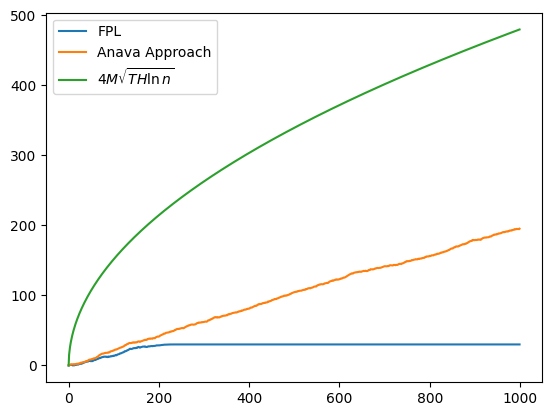

In [88]:
# Let us now implement both the algorithms listed above on stochastically generated heterogenous cost for each action.
T = 1000 # Time Horizon
H = 100   # History Horizon
N = 10   # Number of actions

# 2. Stochastically generated heterogenous cost functions.
# Randomly generate the lower and upperbounds of n uniform RVs that will give us the cost function. 
a = -0.2*np.random.uniform(size=N)
b = a-0.8*np.random.uniform(size=N)

# The clearly we have.
M=1

# Defining eps/eta value for history dependent FTPL and SDAlgo.
eps_FPL_Hist = 2/M*math.sqrt((np.log(N)+1)/(T-H)/(H+2))  # From Hebbar and Langbort paper.
eta_SD_Alg = n*M*np.sqrt((1+np.log(T+1))/(H*T))        # Anava et. al paper. 

# Generate sequence of cost functions.
sum_cost_vec=np.zeros(N)          # This is updated every round.
sum_cost_vec_list=np.zeros([T,N]) # Saving the sum of cost vectors until every time step for plotting purpose. This is just for sanity checks during plotting can delete this later. 

# Storing incurred costs and regret of History Dep FPL
tot_cost_FPL=0                    # Total cost incurred so far.      
tot_cost_list_FPL=np.zeros(T)     # Saving the cost incurred so far at every step for regret plotting. 
regret_FPL = np.zeros(T)          # Saving the regret at every step for plotting.

# Generating seed for FTPL.
# We pick a randomized but constant seed for FTPL perturbations generation. 
# If we want a new perturbation everytime we will set seed=None FollowPerturbedLeader() is called.
seed_FPL = int(1000*(np.random.uniform()))

# Storing incurred costs and regret of SD_Algo.
tot_cost_SDAlg=0
tot_cost_list_SDAlg=np.zeros(T)
regret_SDAlg = np.zeros(T)
W = np.ones(N)                               # Initializing weights for SD Algo.
SDAlg_act = np.random.choice(np.arange(N))   # Initializing a random action for SD algo.

# Creating the time averaging dynamics classes - one copy each for the the FPL and SD algo.
time_avg_calculator_FPL = TimeAverageCalculator(h=H)
time_avg_calculator_SDAlg = TimeAverageCalculator(h=H)


for t in range(T):
    # Generate the FTPL action and state. We don't want  
    FPL_act=FollowPerturbedLeader(sum_cost_vec,eps_FPL_Hist,seed=seed_FPL)
    FPL_state = time_avg_calculator_FPL.add_vector(vectorize_act(N,FPL_act))
    print('FPL Action:',vectorize_act(N,FPL_act), ' State:',FPL_state)
    
    # Generate the SDAlg state from the action already picked for this round.
    SDAlg_state = time_avg_calculator_SDAlg.add_vector(vectorize_act(N,SDAlg_act))
    print('SDAlg Action:',vectorize_act(N,SDAlg_act), ' State:',SDAlg_state)
    
    # Generate the next cost function.
    cost_vec = np.random.uniform(b,a)
    
    # print(cost_vec)
    sum_cost_vec+=cost_vec                    # FPL needs this for the next round.
    # sum_cost_vec_list[t]=sum_cost_vec         # Can comment this later don't need this for anything but plotting   

    # Using the cost functions, past weights and past actions to generate the next action and state in the Anava et. al approach.
    W,SDAlg_act=ShrinkDartOCOAlgo(SDAlg_act, cost_vec+M*np.ones(N), W, eta_SD_Alg)
    
    # # Compute the cost incurred.
    tot_cost_FPL+=np.dot(cost_vec,FPL_state)
    tot_cost_list_FPL[t]=tot_cost_FPL
    tot_cost_SDAlg+=np.dot(cost_vec,SDAlg_state)
    tot_cost_list_SDAlg[t]=tot_cost_SDAlg
    
    # Obtaining the regret.
    regret_FPL[t]=tot_cost_FPL-np.min(sum_cost_vec)
    regret_SDAlg[t]=tot_cost_SDAlg-np.min(sum_cost_vec)
    
plt.plot(np.arange(T),regret_FPL,label='FPL')
plt.plot(np.arange(T),regret_SDAlg,label='Anava Approach')
# Here $H$ is a bad thing to incorporate because when things are randomized the states are also basically uniform spread 
# and in expectation give the same cost as taking each pure action. So the regret it comparable to the no history case.
# plt.plot(np.arange(T),M*np.arange(T)**0.5*np.log(N)**0.5,label='$4M\sqrt{T \ln{n}}$')
plt.plot(np.arange(T),M*np.arange(T)**0.5*np.log(N)**0.5*H**0.5,label='$4M\sqrt{TH \ln{n}}$')
plt.legend()


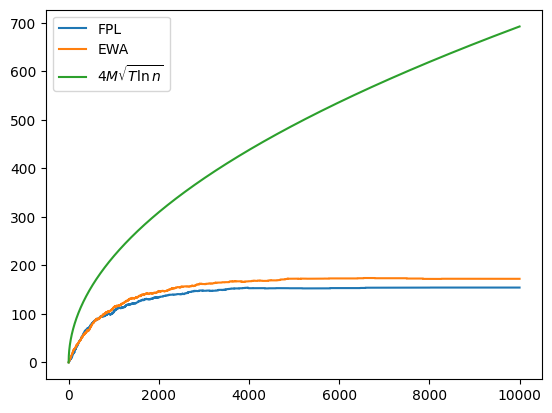

In [62]:
# Let us test this basic FTPL algorithm over horizon length T.
T = 10000     # Horizon length
N = 20       # Number of actions

# 1. Stochastically generated heterogenous cost functions.
# Randomly generate the lower and upperbounds of n uniform RVs that will give us the cost function. 
a = -0.2*np.random.uniform(size=N)
b = a-0.8*np.random.uniform(size=N)
# print(a,b)
# Clearly then our upperbound on the size of the cost vector is 1.
M=1

# eps value for standard FTPL and EWA.
eps_FPL = 1/M*math.sqrt(np.log(N)/T)
eps_EWA = 1/M*math.sqrt(np.log(N)/T)


# Generate sequence of cost functions.
sum_cost_vec=np.zeros(N)
sum_cost_vec_list=np.zeros([T,N])

# Storing costs and regret of FPL
tot_cost_FPL=0
tot_cost_list_FPL=np.zeros(T)
regret_FPL = np.zeros(T)

# Generating seed for FTPL.
# We pick a randomized but constant seed for FTPL perturbations generation. 
# If we want a new perturbation everytime we will set seed=None when FollowPerturbedLeader() is called.
seed_FPL = int(1000*(np.random.uniform()))

# Storing costs and regret of EWA
tot_cost_EWA=0
tot_cost_list_EWA=np.zeros(T)
regret_EWA = np.zeros(T)
W = np.ones(N) # Weights

for t in range(T):
    # Generate the FTPL action.
    FPL_act=FollowPerturbedLeader(sum_cost_vec,eps_FPL,seed=None)

    # Generate the next cost function.
    cost_vec = np.random.uniform(b,a)
    # print(cost_vec)
    sum_cost_vec+=cost_vec
    sum_cost_vec_list[t]=sum_cost_vec 

    # Generate the EWA action and update weights.
    W,EWA_act=ExpWeightsAlgo(W,cost_vec,eps_EWA)
    
    # Compute the cost incurred.
    tot_cost_FPL+=cost_vec[FPL_act]
    tot_cost_list_FPL[t]=tot_cost_FPL
    tot_cost_EWA+=cost_vec[EWA_act]
    tot_cost_list_EWA[t]=tot_cost_EWA
    
    # Obtaining the regret.
    regret_FPL[t]=tot_cost_FPL-np.min(sum_cost_vec)
    regret_EWA[t]=tot_cost_EWA-np.min(sum_cost_vec)
    
plt.plot(np.arange(T),regret_FPL,label='FPL')
plt.plot(np.arange(T),regret_EWA,label='EWA')
plt.plot(np.arange(T),4*M*np.arange(T)**0.5*np.log(N)**0.5,label='$4M\sqrt{T \ln{n}}$')
plt.legend()
# plt.plot(np.arange(T),sum_cost_vec_list[:,0])
# 2. Round robin cost functions with L length lock.

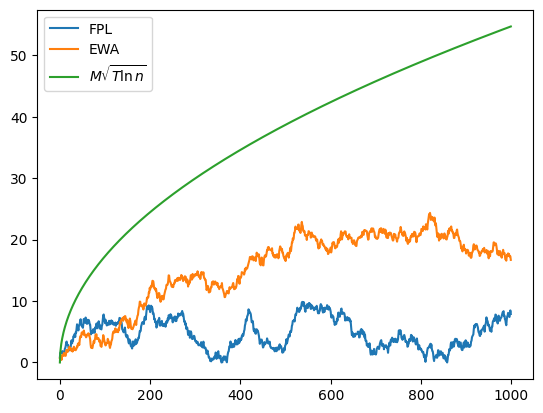

In [61]:

# Let us test this basic FTPL algorithm over horizon length T.
T = 1000     # Horizon length
N = 20       # Number of actions

# 2. Stochastically generated homogenous cost functions. Each action costs uniform [0,1].
M=1

# eps value for standard FTPL and EWA.
eps_FPL = 1/M*math.sqrt(np.log(N)/T)
eps_EWA = 1/M*math.sqrt(np.log(N)/T)

# Generate sequence of cost functions.
sum_cost_vec=np.zeros(N)
sum_cost_vec_list=np.zeros([T,N])

# Storing costs and regret of FPL
tot_cost_FPL=0
tot_cost_list_FPL=np.zeros(T)
regret_FPL = np.zeros(T)

# Generating seed for FTPL.
# We pick a randomized but constant seed for FTPL perturbations generation. 
# If we want a new perturbation everytime we will set seed=None when FollowPerturbedLeader() is called.
seed_FPL = int(1000*(np.random.uniform()))

# Storing costs and regret of EWA
tot_cost_EWA=0
tot_cost_list_EWA=np.zeros(T)
regret_EWA = np.zeros(T)
W = np.ones(N) # Weights

for t in range(T):
    # Generate the FTPL action.
    FPL_act=FollowPerturbedLeader(sum_cost_vec,eps_FPL,seed=seed_FPL)

    # Generate the next cost function.
    cost_vec = -M*np.random.uniform(size=N)
    # print(cost_vec)
    sum_cost_vec+=cost_vec
    sum_cost_vec_list[t]=sum_cost_vec 

    # Generate the EWA action and update weights.
    W,EWA_act=ExpWeightsAlgo(W,cost_vec,eps_EWA)
    
    # Compute the cost incurred.
    tot_cost_FPL+=cost_vec[FPL_act]
    tot_cost_list_FPL[t]=tot_cost_FPL
    tot_cost_EWA+=cost_vec[EWA_act]
    tot_cost_list_EWA[t]=tot_cost_EWA
    
    # Obtaining the regret.
    regret_FPL[t]=tot_cost_FPL-np.min(sum_cost_vec)
    regret_EWA[t]=tot_cost_EWA-np.min(sum_cost_vec)
    
plt.plot(np.arange(T),regret_FPL,label='FPL')
plt.plot(np.arange(T),regret_EWA,label='EWA')
plt.plot(np.arange(T),M*np.arange(T)**0.5*np.log(N)**0.5,label='$M\sqrt{T \ln{n}}$')
plt.legend()
# plt.plot(np.arange(T),sum_cost_vec_list[:,0])


In [ ]:
# Let us test this basic FTPL algorithm over horizon length T.
T = 10000     # Horizon length
N = 20       # Number of actions

# 3. Round robin cost functions with L length lock.
L=100

# Each of the N cost functions will occur in round robin fashion switching after a period of L at a time. 
costs=-1*np.eye(N)

# Clearly then our upperbound on the size of the cost vector is 10.
M=1

# eps value for standard FTPL and EWA.
eps_FPL = 1/M*math.sqrt(np.log(N)/T)
eps_EWA = 1/M*math.sqrt(np.log(N)/T)

# Generate sequence of cost functions.
sum_cost_vec=np.zeros(N)
sum_cost_vec_list=np.zeros([T,N])

# Storing costs and regret of FPL
tot_cost_FPL=0
tot_cost_list_FPL=np.zeros(T)
regret_FPL = np.zeros(T)

# Storing costs and regret of EWA
tot_cost_EWA=0
tot_cost_list_EWA=np.zeros(T)
regret_EWA = np.zeros(T)
W = np.ones(N) # Weights

for t in range(T):
    # Generate the FTPL action.
    FPL_act=FollowPerturbedLeader(sum_cost_vec,eps_FPL,fixed_pert=False)

    # Generate the next cost function.
    cost_vec = costs[(int(t/L))%2,:]
    # if t<T:
        # cost_vec = costs[(int(t/L))%N%2,:]
    # else:
        # cost_vec = costs[(int(t/L))%N%2+2,:]
    # print(cost_vec)
    sum_cost_vec+=cost_vec
    sum_cost_vec_list[t]=sum_cost_vec 

    # Generate the EWA action and update weights.
    W,EWA_act=ExpWeightsAlgo(W,cost_vec,eps_EWA)
    
    # Compute the cost incurred.
    tot_cost_FPL+=cost_vec[FPL_act]
    tot_cost_list_FPL[t]=tot_cost_FPL
    tot_cost_EWA+=cost_vec[EWA_act]
    tot_cost_list_EWA[t]=tot_cost_EWA
    
    # Obtaining the regret.
    regret_FPL[t]=tot_cost_FPL-np.min(sum_cost_vec)
    regret_EWA[t]=tot_cost_EWA-np.min(sum_cost_vec)
    
plt.plot(np.arange(T),regret_FPL,label='FPL')
plt.plot(np.arange(T),regret_EWA,label='EWA')
plt.plot(np.arange(T),4*M*np.arange(T)**0.5*np.log(N)**0.5,label='$4M\sqrt{T \ln{n}}$')
plt.legend()
# plt.plot(np.arange(T),sum_cost_vec_list[:,0])

In [ ]:
# for t in range(T):
#     print((int(t/L))%N%5)
# plt.plot(np.arange(T),np.min(sum_cost_vec_list[:,:],axis=1))

In [ ]:
# plt.plot(np.arange(T),sum_cost_vec_list[:,:])
# 

In [90]:
# np.min(regret)
# np.log(10)

2.302585092994046

In [ ]:
# np.min(sum_cost_vec_list[:,:],axis=1)

In [ ]:
test=np.array([1,2,3,4])
len(test)

In [ ]:
a=np.random.random(4)
b=np.random.random(4)
a,b,a*b